# Preamble

In [1]:
%load_ext autoreload
%autoreload 2

# disable parallelization for BLAS and co.
from nalabtools.utils.parallelization import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)

# general
import re
import collections
import pickle

# data
import numpy as np
import pandas as pd

# ml / stats
import sklearn
import statsmodels.stats.multitest

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nalab
import nalabtools

# init notebook files
import nalabtools.utils.misc
nb = nalabtools.utils.misc.NotebookContext("martin_001_deepinsight")

In [2]:
%load_ext rpy2.ipython

/home/mgbckr/anaconda3/envs/nalab-butterfly/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
%%R
R.home()

[1] "/home/mgbckr/anaconda3/envs/nalab-butterfly/lib/R"


# Load data

## AFCS

In [4]:
import nalabafcs.automate.run.steps
data_fcs = nalabafcs.automate.run.steps.load_fcs(n_jobs=3)

/home/mgbckr/Documents/workspaces/nalab-tools/src/nalabtools/utils/parallelization.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")
R[write to console]: Loading required package: foreach

R[write to console]: Loading required package: iterators

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:flowCore’:

    filter


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Normalization

In [5]:
preprocessing = sklearn.preprocessing.MinMaxScaler().fit(data_fcs.features)
data_features = preprocessing.transform(data_fcs.features)

# Test embeddings

Embedding packages:
* https://github.com/DmitryUlyanov/Multicore-TSNE
* https://github.com/pavlin-policar/openTSNE
* https://github.com/CannyLab/tsne-cuda
* https://github.com/lmcinnes/umap
* https://github.com/eamid/trimap

In [15]:
import umap
embedding = umap.UMAP().fit_transform(data_features)

/home/mgbckr/anaconda3/envs/nalab-butterfly/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/envs/nalab-butterfly/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/mgbckr/anaconda3/envs/nalab-butterfly/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

Fi

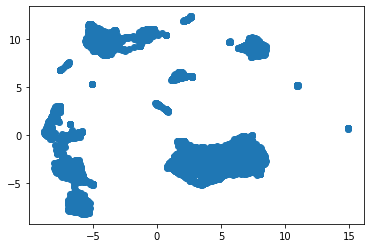

In [16]:
plt.scatter(embedding[:,0], embedding[:,1])

In [6]:
import openTSNE
openTSNE.__version__

'0.3.12'

In [44]:
from openTSNE import TSNE
embedding = TSNE().fit_transform(data_features)

AttributeError: 'TSNE' object has no attribute 'fit_transform'

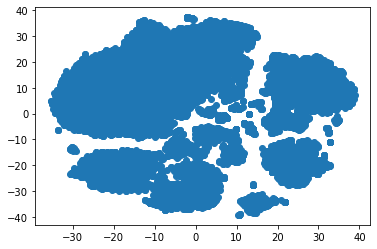

In [8]:
plt.scatter(embedding[:,0], embedding[:,1])

In [11]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=1)
embedding = tsne.fit_transform(data_features)

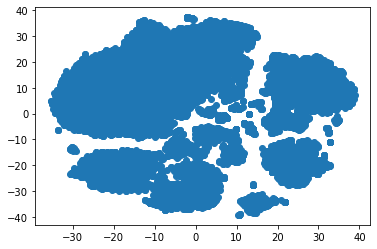

In [12]:
plt.scatter(embedding[:,0], embedding[:,1])

In [13]:
import trimap
embedding = trimap.TRIMAP().fit_transform(data_features)

TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean,lr=1000.0, n_iters=400, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 30000 points with dimension 37
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 760.289, Violated triplets: 0.0461
Iteration:  200, Loss: 697.732, Violated triplets: 0.0423
Iteration:  300, Loss: 657.872, Violated triplets: 0.0399
Iteration:  400, Loss: 631.594, Violated triplets: 0.0383
Elapsed time: 0:00:26.020972


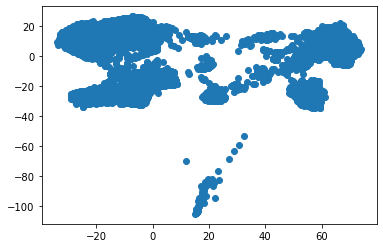

In [14]:
plt.scatter(embedding[:,0], embedding[:,1])

In [17]:
import sklearn.decomposition
embedding = sklearn.decomposition.PCA(n_components=2).fit_transform(data_features)

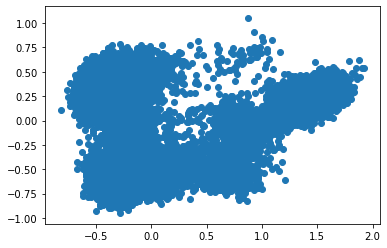

In [18]:
plt.scatter(embedding[:,0], embedding[:,1])

In [21]:
import sklearn.decomposition
embedding = sklearn.decomposition.KernelPCA(n_components=2, kernel="rbf").fit_transform(data_features)

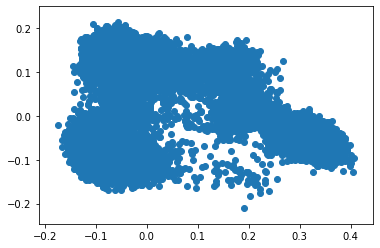

In [22]:
plt.scatter(embedding[:,0], embedding[:,1])

# Test single cell album transformer

Embedding


group:     0, row:   8, col:  38: : 0it [00:00, ?it/s]

Rotating
Images


group:     2, row:  39, col:  39: : 3it [00:02,  1.11it/s]


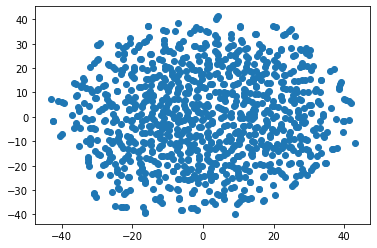

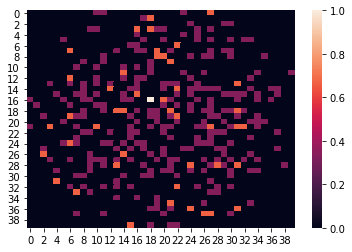

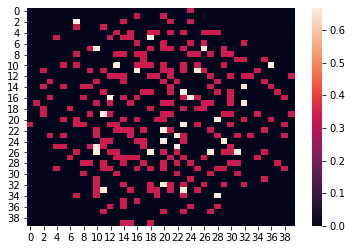

In [43]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X = np.random.random((1000, 20))
groups = np.random.choice([1,2,3], 1000)

import butterfly.deepinsight.album2
t =butterfly.deepinsight.album2.SingleCellTransformer(size=40, store_embeddings=True)
X_album = t.fit_transform(X, groups)

plt.scatter(t.X_embedded_[:,0], t.X_embedded_[:,1])
plt.figure()
plt.scatter(t.X_rotated_[:,0], t.X_rotated_[:,1])
sns.heatmap(X_album[0, 0, :])
plt.figure()
sns.heatmap(X_album[1, 0, :])

# Derive images and dataset

In [73]:
# sklearn.preprocessing.LabelEncoder().fit_transform(data_fcs.index.values)
# data_fcs.index.values == data_fcs.index.values[0]
data_fcs.index.factorize()

(array([0, 0, 0, ..., 2, 2, 2]),
 MultiIndex([('ptlg001', 2.0),
             ('ptlg001', 3.0),
             ('ptlg002', 2.0)],
            ))

Embedding


group:     0, row:  20: : 0it [00:00, ?it/s]

Rotating
Images


group:     2, row:  39: : 3it [00:00,  3.63it/s]


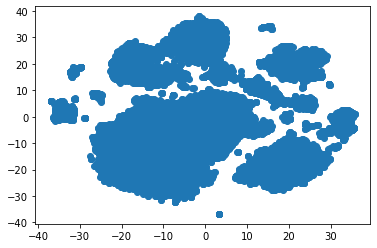

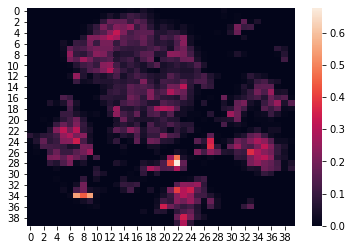

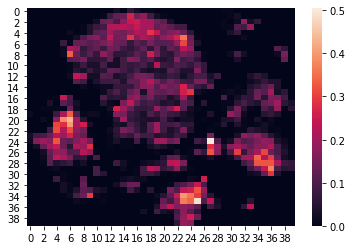

In [75]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import butterfly.deepinsight.album2

tsne = TSNE(n_jobs=6)
t =butterfly.deepinsight.album2.SingleCellTransformer(size=40, embedding_algorithm=lambda X: tsne.fit_transform(X), store_embeddings=True)
X_album = t.fit_transform(data_features, data_fcs.index.factorize()[0])

plt.scatter(t.X_embedded_[:,0], t.X_embedded_[:,1])
plt.figure()
plt.scatter(t.X_rotated_[:,0], t.X_rotated_[:,1])
sns.heatmap(X_album[0, 0, :])
plt.figure()
sns.heatmap(X_album[1, 0, :])

In [62]:
import torch.utils.data
dataset_train = butterfly.deepinsight.album2.AlbumDataset(X_train_album[:,[1],:,:], y_train)
dataset_val = butterfly.deepinsight.album2.AlbumDataset(X_val_album[:,[1],:,:], y_val)
dataset_test = butterfly.deepinsight.album2.AlbumDataset(X_test_album[:,[1],:,:], y_test)

In [71]:
bs = 64
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=bs, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=bs * 2)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=bs * 2)

# Network

In [64]:
import torch.optim as optim
import butterfly.deepinsight.deepinsight
from tqdm import tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter



In [ ]:
writer = SummaryWriter(nb.folder('runs/exp4'))

In [65]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

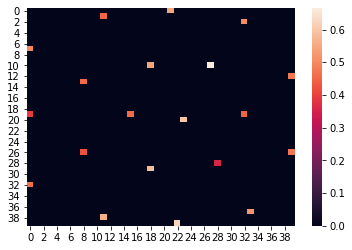

In [129]:
sns.heatmap(X_train_album[0,1,:])

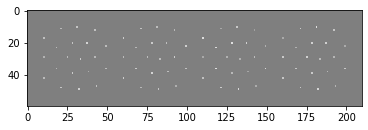

In [128]:
img_grid = torchvision.utils.make_grid(torch.from_numpy(X_train_album[:4,[1],:,:]), padding=10)

writer.add_image('test_image', img_grid)
matplotlib_imshow(img_grid)

In [70]:
import butterfly.deepinsight.deepinsight
m = butterfly.deepinsight.deepinsight.DeepInsight(
    input_dim=X_train_album.shape[2:],
    kernel_size1=1, kernel_size2=2, n_initial_filters=1)


dataiter = iter(dataloader_train)
images, labels = dataiter.next()

writer.add_graph(m, images[:4,:])
writer.flush()

In [37]:
# # embeddings
# # Bugfix: https://github.com/pytorch/pytorch/issues/30966
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# features = images.view(-1, 40 * 40)
# writer.add_embedding(features,
#                     metadata=labels,
#                     label_img=images.unsqueeze(1))
# writer.close()

In [72]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(m.parameters(), lr=0.001, momentum=0.9, )
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)

pbar = tqdm(range(100))
for epoch in pbar:  # loop over the dataset multiple times

    m.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = m(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        every = 30
        if i % every == every - 1:
            
            m.eval()
            
            with torch.no_grad():
                loss_val = sum(criterion(m(x), y) for x, y in dataloader_val)
                loss_val /= len(dataloader_val)
                
            loss_train = running_loss / every
            writer.add_scalars("loss", dict(train=loss_train, validation=loss_val), epoch * len(dataloader_train) + i)
            running_loss = 0.0
            
            pbar.set_description(f"Processing [epoch={epoch}, batch={i:2d}] training_loss={running_loss / every:.03f}")
            
            m.train()
        
            
print('Finished Training')

Processing [epoch=99, batch=89] training_loss=0.000: 100%|██████████| 100/100 [04:56<00:00,  2.97s/it]

Finished Training


# TODOS
- [x] visualize validation loss
- [x] visualize images ... everyhting else in the tensorboard tutorial
- [ ] get AFCS files and run the first single cell thingy


In [73]:
y_pred_proba = m(torch.tensor(X_train_album[:,[1],:,:]).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
sklearn.metrics.accuracy_score(y_pred, y_train)

0.960328749802434

In [74]:
y_pred_proba = m(torch.tensor(X_test_album[:,[1],:,:]).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
sklearn.metrics.accuracy_score(y_pred, y_test)

0.9540540540540541

In [75]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(X_train_raw, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
sklearn.metrics.accuracy_score(rf.predict(X_train_raw), y_train)

1.0

In [77]:
sklearn.metrics.accuracy_score(rf.predict(X_test_raw), y_test)

0.9581081081081081